In [1]:
import arviz as az

import corner
import cornerhex

import pickle

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time

import pandas as pd

import json as js
from tqdm import tqdm
    
from snuddd.jinterp import interp1d

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #select GPU, -1 means use CPU

from jax import config
config.update("jax_enable_x64", True)

In [3]:
import jax
import jax.numpy as jnp

from snuddd import config
from snuddd.targets import Nucleus, electron_xe, Electron
from snuddd.models import GeneralNSI

import numpyro
from numpyro import optim
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro import infer
from numpyro.infer import MCMC, NUTS, autoguide, reparam
from numpyro.handlers import trace, seed
from numpyro.infer.util import log_density

2024-05-18 23:44:27.502674: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 11.2 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
Xe_nucleus = Nucleus(54, 132, mass=131.9041535 * config.u)

In [6]:
SM_matrix = np.array([[0, 0, 0],
                      [0, 0, 0],
                      [0, 0, 0]])

SM_eta = 0
SM_phi = 0

sm_model = GeneralNSI(SM_matrix, SM_eta, SM_phi)

In [20]:
Xe_nucleus.update_model(sm_model)
Xe_nucleus.prepare_density()

In [21]:
E_Rs = np.logspace(-1, 1, 100) / 1e6 # Recoil Energy in GeV 

sm_spec=Xe_nucleus.spectrum(E_Rs, nu = '8B')

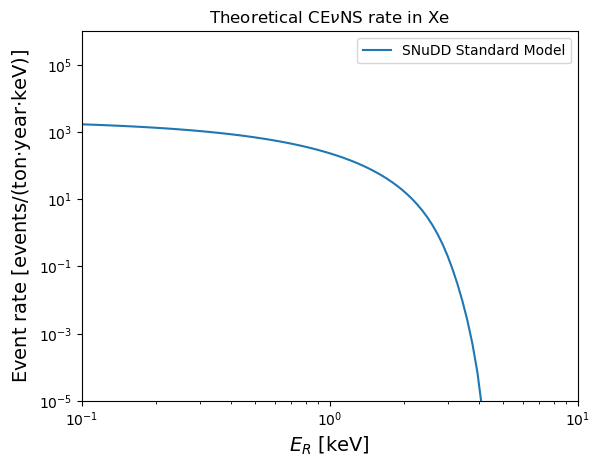

In [22]:
plt.loglog(E_Rs*1e6, abs(sm_spec), label="SNuDD Standard Model") # abs because of the residual imaginary part from the density matrix. All elements have zero imaginary part anyway.
plt.legend()
plt.title(r"Theoretical CE$\nu$NS rate in Xe")
plt.ylabel(r'${\rm d}R/{\rm d}E_R\,\,\left[{\rm ton}^{-1}\,{\rm yr}^{-1}\,{\rm keV}^{-1}\right]$', size=14)
plt.xlabel(r'$E_{R}\,\,\left[{\rm keV}\right]$', size=14)

plt.ylabel(r"Event rate [events/(ton$\cdot$year$\cdot$keV)]")

plt.xlim(xmin=1e-1, xmax=1e1)
plt.ylim(ymax=1e6, ymin=1e-5)

plt.show()

In [23]:
""" IN SI UNIT """
""" Reduced Planck Constant in J·s """
HBAR = 1.054571800E-34
""" Speed of Light in m/s """
C = 2.99792458E8
""" Avogaro's Number in 1/mol """
A_V = 6.022140857E23
""" Charge of Electron in C """
CH_E = 1.6021766208E-19

""" keV in J """
KEV = 1e3 * CH_E
""" GeV in J """
GEV = 1e9 * CH_E

GeV = 1.0
MeV = GeV / 1e3
keV = GeV / 1e6
eV = GeV / 1e9

# GeV ^ -1
m = 1.0 / (HBAR * C / GEV) / GeV
cm = m / 1e2
km = m * 1e3
mm = m / 1e3
um = m / 1e6
nm = m / 1e9
pm = m / 1e12
fm = m / 1e15

# GeV
kg = 1.0 * C**2 / GEV * GeV
ton = kg * 1e3
g = kg * 1e-3

# GeV ^ -1
sec = 1.0 * C * m
dy = 24.0 * 3600.0 * sec
yr = 365.0 * dy

# Fermi's const
Gf = 1.1663787e-5 / GeV**2

# Neutron mass
mn = 0.9314940954 * GeV

# Mixing angle
sin2the = 0.2223

In [24]:
NSI_matrix = np.array([[0.0, 0.0, 0.0],
                       [0.0, 0.0, 0.0],
                       [0.0, 0.0, 0.0]])

NSI_eta = 0
NSI_phi = 0

NSI_model = GeneralNSI(NSI_matrix, NSI_eta, NSI_phi)

Xe_nucleus.update_model(NSI_model)
Xe_nucleus.prepare_density()

NSI_spec=Xe_nucleus.spectrum(E_Rs, nu = '8B')

acc_data = pd.read_csv('acceptance.csv').drop(columns='Unnamed: 0')

accept = np.array(acc_data['acceptance'])
energy = np.array(acc_data['energy'] * keV)
accept = interp1d(energy, accept)

In [25]:
Xe_electron = Electron(Xe_nucleus, None, None)
Xe_electron.update_model(NSI_model)
Xe_electron.prepare_density()

In [26]:
er = energy
tot_rate = (np.abs(Xe_nucleus.spectrum(er, nu = '8B')) * accept(er).astype("float64") * (yr**(-1) * keV**(-1) * ton**(-1)))

delta_energy = er[1] - er[0]
total_rate = np.sum(tot_rate) * delta_energy
upper_lim_B8_flux = 5.25e6 * 2.3 * cm**-2 * sec**-1
lower_lim_B8_flux = 5.25e6 * 0.9 * cm**-2 * sec**-1
tot_flux = 5.46e6 * cm**-2 * sec**-1
upper_lim_total_rate = total_rate / tot_flux * upper_lim_B8_flux
lower_lim_total_rate = total_rate / tot_flux * lower_lim_B8_flux
print("{:} {:.2f} per ty".format("90% UL B8 solar neutrino rate:", upper_lim_total_rate / (yr**(-1) * ton**(-1))))

90% UL B8 solar neutrino rate: 13.12 per ty


In [27]:
er_energies = np.linspace(24, 50, 27)

In [28]:
# %%timeit
pp_sum = jnp.real(jnp.sum(Xe_electron.spectrum(er_energies, nu = 'pp')))

In [29]:
import numpyro
from numpyro import distributions as dist, infer
from numpyro import handlers


# @handlers.reparam(config={"phi": infer.reparam.CircularReparam()})
def nsi_rate(rate = None):
    eps_ee = numpyro.sample("eps_ee", dist.Uniform(-5.0, 5.0))
    eps_em = numpyro.sample("eps_em", dist.Uniform(-5.0, 5.0))
    eps_et = numpyro.sample("eps_et", dist.Uniform(-5.0, 5.0))
    eps_mm = numpyro.sample("eps_mm", dist.Uniform(-5.0, 5.0))
    eps_mt = numpyro.sample("eps_mt", dist.Uniform(-5.0, 5.0))
    eps_tt = numpyro.sample("eps_tt", dist.Uniform(-5.0, 5.0))
    sineta = numpyro.sample("sineta", dist.Uniform(-1., 1.))
    phi = numpyro.sample("phi", dist.Uniform(-0.5 * jnp.pi, 0.5 * jnp.pi))
    
    NSI_matrix = jnp.asarray([[eps_ee, eps_em, eps_et],
                       [eps_em, eps_mm, eps_mt],
                       [eps_et, eps_mt, eps_tt]])
    NSI_eta = jnp.arcsin(sineta)
    NSI_phi = phi

    NSI_model = GeneralNSI(NSI_matrix, NSI_eta, NSI_phi)
    Xe_nucleus.update_model(NSI_model)
    Xe_nucleus.prepare_density()

    tot_rate = jnp.sum(jnp.abs(Xe_nucleus.spectrum(er, nu = '8B')) * accept(er) * (yr**(-1) * keV**(-1) * ton**(-1))) * delta_energy
    tot_lambda = tot_rate * 0.6 * ton * yr + 5.38
    
    # Xe_electron = Electron(Xe_nucleus, None, None)
    Xe_electron.update_model(NSI_model)
    Xe_electron.prepare_density()
    pp_sum_NSI = jnp.real(jnp.sum(Xe_electron.spectrum(er_energies, nu = 'pp')))
    # pp_10kev_NSI = jnp.real(Xe_electron.spectrum(np.array([1.0e-5]), nu = 'pp'))
    
    measured_pp_ratio = numpyro.sample("measured_pp_ratio", dist.TruncatedNormal(1.72, 1.72, low=0.0), obs=pp_sum_NSI/pp_sum)
    
    
    numpyro.sample("rate", dist.Poisson(tot_lambda), obs=rate)

    

    

In [32]:
sampler = infer.MCMC(
    infer.NUTS(nsi_rate, target_accept_prob=0.97, max_tree_depth=3),
    num_warmup=20,
    num_samples=20,
    num_chains=2,
    progress_bar=True,
    chain_method='sequential',
)

In [33]:

%time sampler.run(jax.random.PRNGKey(0), rate = 6)

/home/juehang/.conda/envs/numpyro_gpu/lib/python3.11/site-packages/jax/_src/lax/lax.py:2652: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
sample: 100%|█| 40/40 [00:21<00:00,  1.89it/s, 7 steps of size 6.40e-02. acc. pr
sample: 100%|█| 40/40 [00:04<00:00,  8.84it/s, 7 steps of size 6.35e-02. acc. pr


CPU times: user 54.7 s, sys: 8.05 s, total: 1min 2s
Wall time: 1min 5s


In [35]:
sampler.print_summary()
samples_1 = sampler.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eps_ee      0.32      0.09      0.31      0.19      0.50      5.33      1.59
    eps_em      0.65      1.15      0.82     -0.94      1.91      1.06      5.31
    eps_et      0.67      0.58      0.71     -0.07      1.46      1.06      6.33
    eps_mm      2.36      1.13      2.38      1.22      3.49      1.03     92.22
    eps_mt      2.03      1.20      2.04      0.76      3.26      1.03     24.35
    eps_tt      1.12      1.68      1.30     -0.65      2.85      1.03     18.44
       phi      0.00      0.25      0.05     -0.32      0.25      1.05      7.57
    sineta     -0.17      0.36     -0.17     -0.56      0.21      1.03     24.48

Number of divergences: 0


In [37]:
names = []
for site in trace(seed(nsi_rate, jax.random.PRNGKey(0))).get_trace().values():
    names.append(site['name'])

In [38]:
sample_dict = sampler.get_samples()
last_sample = {}
for k in sample_dict:
    last_sample[k] = sample_dict[k][-1]

In [43]:
import ultranest
import ultranest.calibrator
import ultranest.stepsampler
from ultranest.plot import cornerplot

import logging
import sys

In [44]:
logger = logging.getLogger("ultranest")
logger.setLevel(logging.DEBUG)
logger.propagate = False

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
formatter = logging.Formatter('[ultranest] [%(levelname)s] %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

err_handler = logging.StreamHandler(sys.stderr)
err_handler.setLevel(logging.WARNING)
err_handler.setFormatter(formatter)
logger.addHandler(err_handler)

file_handler = logging.handlers.WatchedFileHandler('ultranest.log')
file_handler.setLevel(logging.DEBUG)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)


In [248]:
@jax.jit
def log_density_func(x, names=names):
    samples = {
        k:v for (k,v) in zip(names, x)
    }
    llh = log_density(nsi_rate, (jnp.array([6.])), {}, samples)[0]
    return jnp.nan_to_num(llh + jnp.log(10**6*2*jnp.pi), nan=-jnp.finfo(jnp.result_type(float)).max)

In [251]:
@jax.jit
def prior_transform(cube):
    highs = jnp.array([5,5,5,5,5,5,1, 0.5 * jnp.pi])
    lows = jnp.array([-5,-5,-5,-5,-5,-5,-1, -0.5 * jnp.pi])
    return cube*(highs - lows) + lows

In [253]:
ns_names = names[:-2]

In [254]:
logger = logging.getLogger("ultranest")

In [260]:

sampler = ultranest.ReactiveNestedSampler(ns_names, log_density_func, prior_transform,
    log_dir="ultranest_no_neutra", resume='overwrite')

In [262]:
starttime = time.time()
result = sampler.run(min_num_live_points=1200, frac_remain=0.02)
endtime = time.time()

[ultranest] [INFO] Sampling 1200 live points from prior ...


/home/juehang/.conda/envs/numpyro_gpu/lib/python3.11/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/40 accepted in iteration 2500). To improve efficiency, modify the transformation so that the current live points (stored for you in ultranest_no_neutra/extra/sampling-stuck-it%d.csv) are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] [INFO] Explored until L=-3  972..-3.1972]*| it/evals=12546/4495106 eff=0.2792% N=1200 
[ultranest] [INFO] Likelihood function evaluations: 4495106
[ultranest] [INFO] Writing samples and results to disk ...
[ultranest] [INFO] Writing samples and results to disk ... done
[ultranest] [INFO]   logZ = -9.707 +- 0.04131
[ultranest] [INFO] Effective samples strategy satisfied (ESS = 4159.6, need >400)
[ultranest] [INFO] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.03 nat, need <0.50 nat)
[ultranest] [INFO] Evidency uncertainty strategy is satisfied (dlogz=0.05, need <0.5)
[ultranest] [INFO]   logZ error budget: single: 0.07 bs:0.04 tail:0.02 total:0.05 required:<0.50
[ultranest] [INFO] done iterating.


| Bottom LLH | eff (slow) (%) | eff (fast) (%) | eff (med) (%) |
| ---------- | -------        | -------------- | --------------|
| -200       | 21             | 21             | 20            | 
| -50        | 13.5           | 12             | 12            | 
| -35        | 12.5           | 10             | 11            | 
| -15        | 10             | 7.2            | 10            | 
| -8         | 8              | 5.7            | 8.8           | 
| -6         | 6.6            | 5.5            | 7.8           | 
| -5         | 5.6            | 5.4            | 6.9           | 
| -4         | 3.8            | 5.0            | 5.0           | 
| -3.9       | 3.4            | 4.9            | 4.7           | 
| -3.7       | 2.4            | 4.35           | 3.6           | 
| -3.5       | 1.4            | 3.5            | <2.4          |
| -3.4       | 0.84           | 3.1            |            |

In [263]:
result['runtime'] = endtime - starttime

In [265]:
## comment out the following two lines if there are no prior runs
with open('ns_runtimes.pickle', 'rb') as f:
    current_results = pickle.load(f)
    
## uncomment if concatenating results with prior runs
# current_results = []

In [266]:
current_results.append(result)
with open('ns_runtimes.pickle', 'wb') as f:
    pickle.dump(current_results, f)

In [268]:
dict_for_plot = {}
for i, n in enumerate(ns_names):
    dict_for_plot[n] = np.concatenate([x['samples'][:,i] for x in current_results])


with open('ns_corner_samples.pickle', 'wb') as f:
    pickle.dump(dict_for_plot, f)

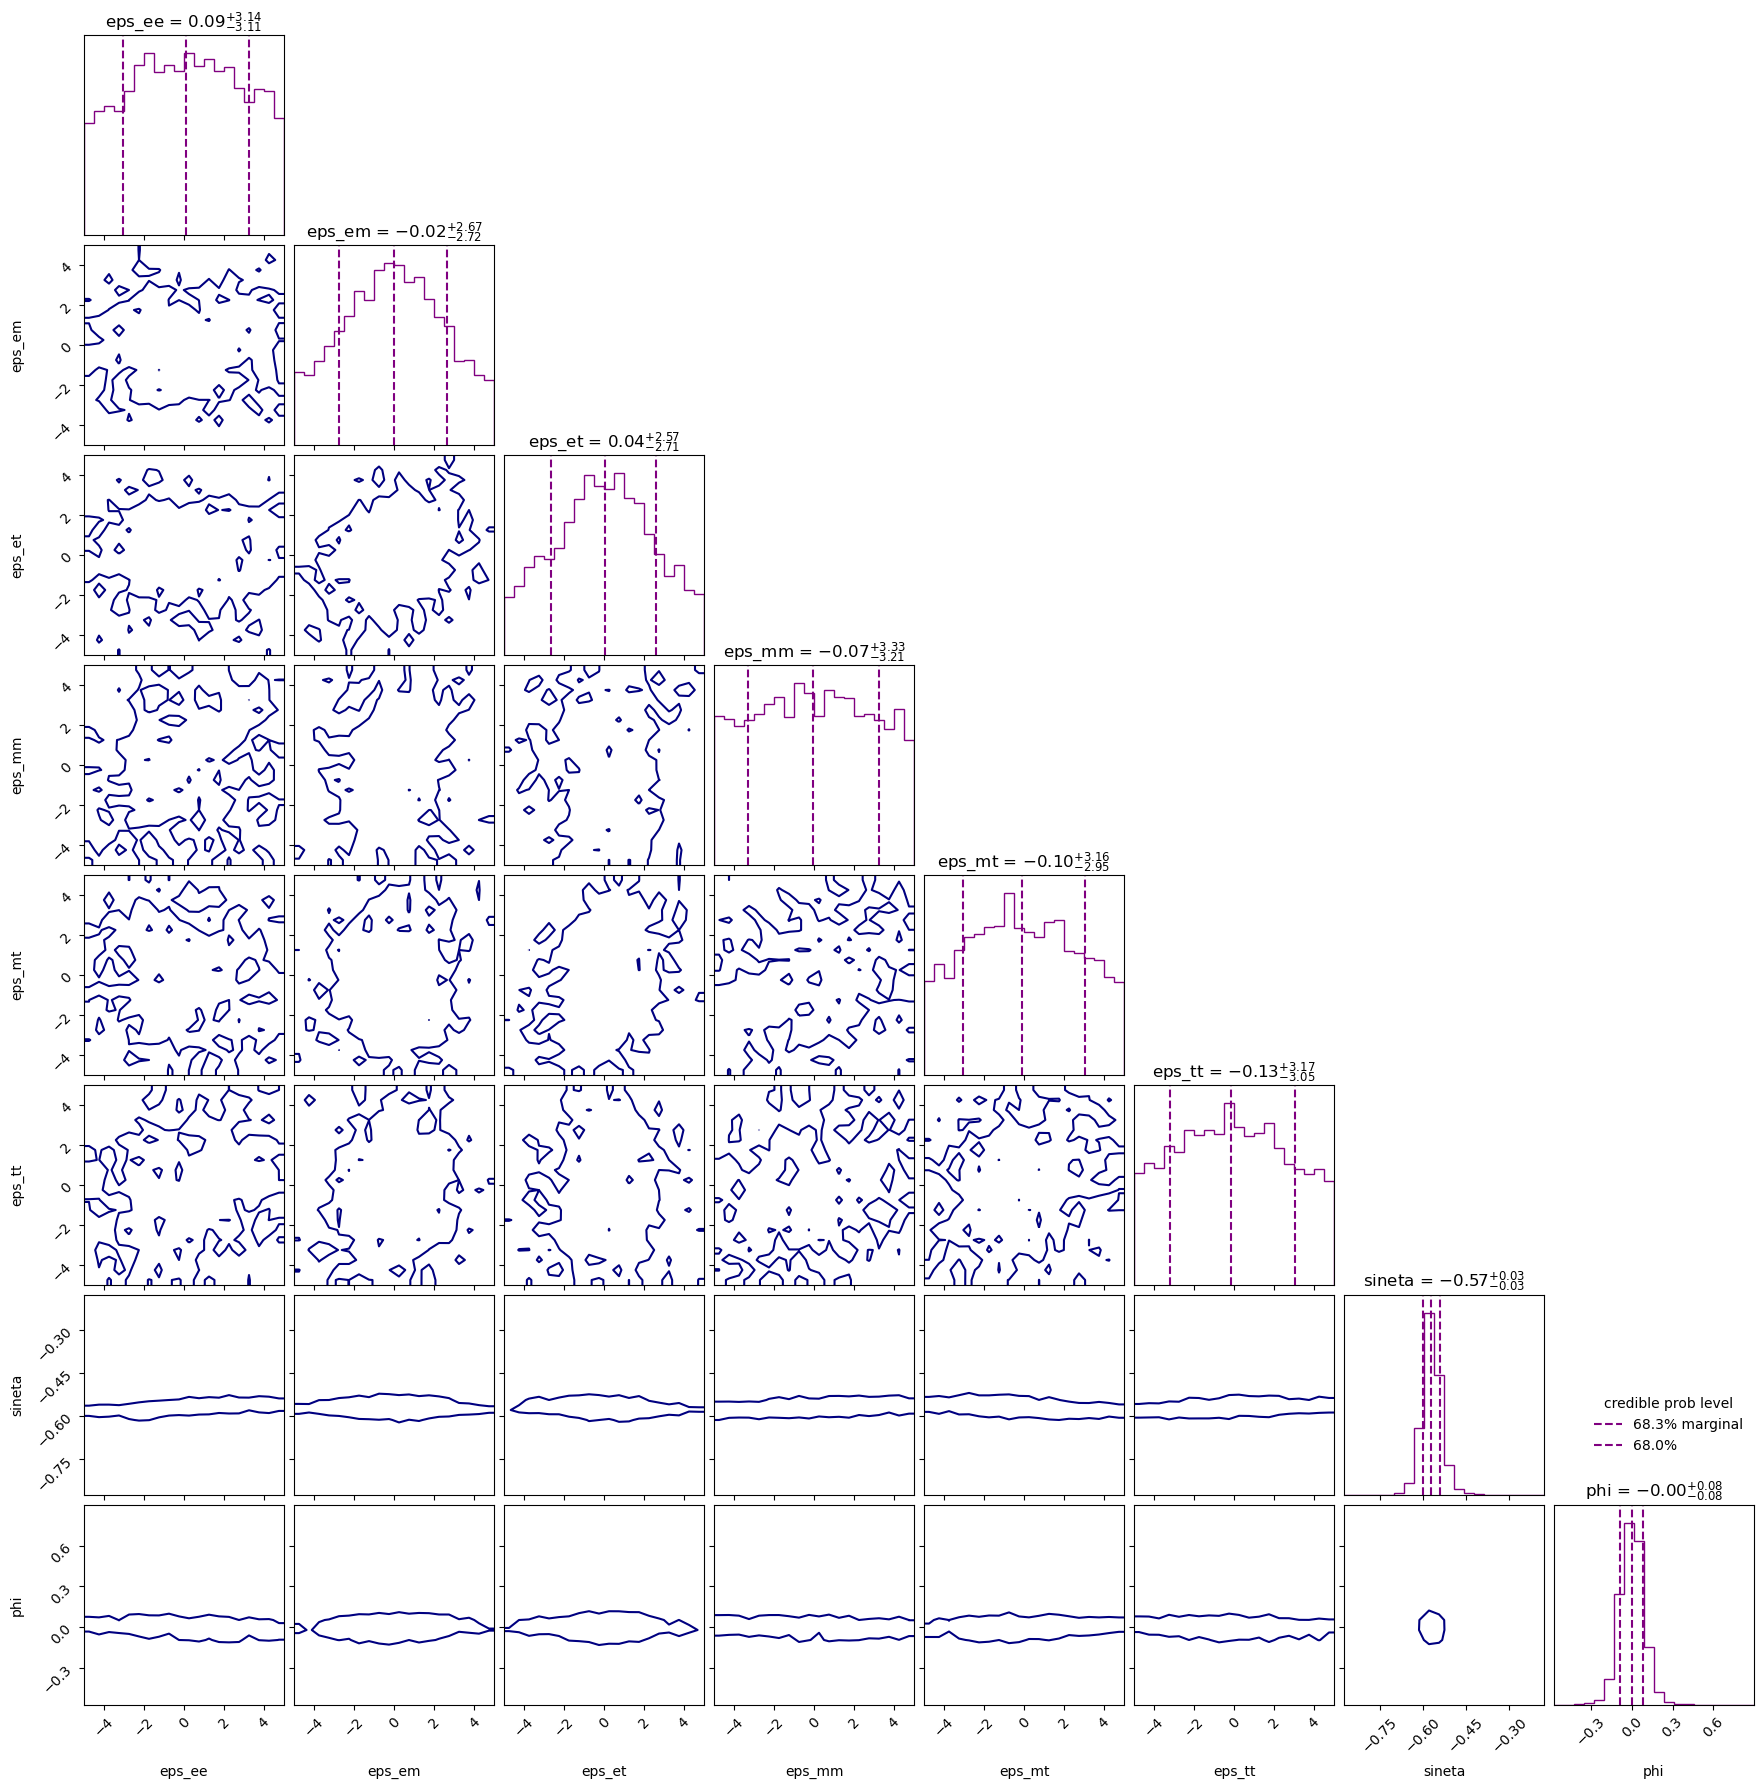

In [273]:
cornerplot(current_results[-1], levels=[0.68])
plt.show()

In [274]:
result['ess']

4159.566222804198

In [275]:
result['ess']/result['runtime']

0.17052546058100826

In [276]:
result['ess']/result['ncall']

0.0009253544238565672

In [277]:
ultranest.__version__

'4.2.0'

In [278]:
sampler.logs

{'run_dir': 'ultranest_no_neutra',
 'info': 'ultranest_no_neutra/info',
 'results': 'ultranest_no_neutra/results',
 'chains': 'ultranest_no_neutra/chains',
 'extra': 'ultranest_no_neutra/extra',
 'plots': 'ultranest_no_neutra/plots'}

In [279]:
import optax

In [96]:
guide = autoguide.AutoBNAFNormal(
    nsi_rate,
    hidden_factors=[10, 10],
    num_flows=3
    )

# guide = autoguide.AutoIAFNormal(
#     nsi_rate,
#     hidden_dims=[30,30],
#     num_flows=5
# )

# guide = autoguide.AutoNormal(nsi_rate)


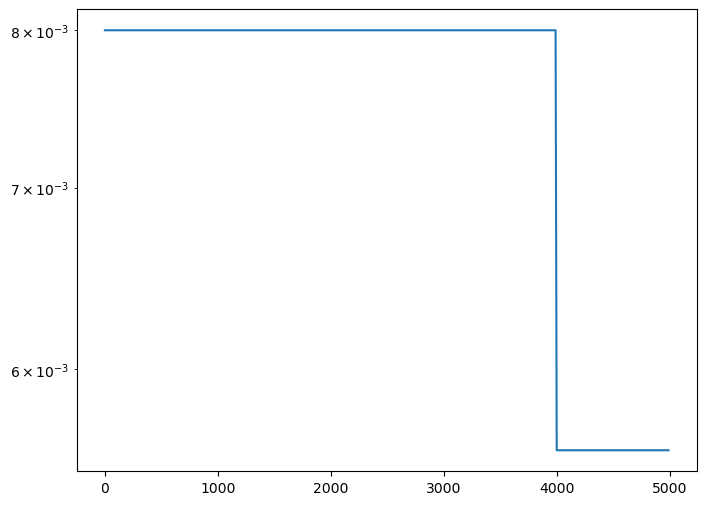

In [97]:
N_1 = 4000
N_2 = 1000
epochs = N_1 + N_2
high_lr = 0.8e-2
lr_multiplier = 0.7
# schedule = optax.join_schedules([optax.cosine_decay_schedule(high_lr, N_1, alpha=lr_multiplier), optax.cosine_decay_schedule(high_lr, N_2, alpha=lr_multiplier)], [N_1])
# schedule = optax.join_schedules([optax.constant_schedule(high_lr), optax.cosine_decay_schedule(high_lr, N_2, alpha=lr_multiplier)], [N_1])
schedule = optax.join_schedules([optax.constant_schedule(high_lr), optax.constant_schedule(high_lr*lr_multiplier)], [N_1])
x = np.arange(0, epochs, 10)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(
    x,
    [schedule(i) for i in x],
)
ax.set(yscale='log')
plt.show()

In [98]:
svi = infer.SVI(nsi_rate, guide, optax.adamw(schedule), infer.Trace_ELBO(num_particles=30))

In [ ]:
## As a hack, this needs to be run to initialize the guide, but if weights are being loaded later this does not have to be run for more than a single epoch.
svi_result = svi.run(jax.random.PRNGKey(0), epochs, rate=6)

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(svi_result.losses)
ax.plot(np.arange(10, len(svi_result.losses)-10), np.convolve(svi_result.losses, [1/21]*21, mode='valid'))
ax.set(yscale='log', ylim=[np.min(svi_result.losses)*0.9, svi_result.losses[100]])
plt.show()

In [101]:
with open("params_with_sineta_pp_2.pickle", "rb") as f:
    loaded_dict = pickle.load(f)

In [102]:
neutra = infer.reparam.NeuTraReparam(guide, loaded_dict)
neutra_model = neutra.reparam(nsi_rate)

In [103]:
neutra_names = []
for site in trace(seed(neutra_model, jax.random.PRNGKey(0))).get_trace().values():
    neutra_names.append(site['name'])

In [287]:
@jax.jit
def prior_transform_nn(cube, scale=2):
    return jax.scipy.special.logit(cube)*scale

In [288]:
@jax.jit
def inverse_prior_nn(x, scale=2):
    return jax.nn.sigmoid(x/scale)

In [289]:
prior_jac_nn = jax.jit(jax.jacfwd(prior_transform_nn))

In [290]:
@jax.jit
def log_density_func_nn(x, names=names):
    # x = jnp.concatenate([eps, phi, sineta])
    samples = {
        'auto_shared_latent': x
    }
    llh = log_density(neutra_model, (jnp.array([6.])), {}, samples)[0]
    return jnp.nan_to_num(llh + jnp.linalg.slogdet(prior_jac_nn(inverse_prior_nn(x)))[1], nan=-jnp.finfo(jnp.result_type(float)).max)

In [294]:
nn_names = [f'latent_{i}' for i in range(8)]

In [349]:

sampler_nn = ultranest.ReactiveNestedSampler(nn_names, log_density_func_nn, prior_transform_nn,
    log_dir="ultranest_w_neutra", resume='overwrite')

In [350]:
starttime = time.time()
result_nn = sampler_nn.run(min_num_live_points=600, frac_remain=0.02)
endtime = time.time()

[ultranest] [INFO] Sampling 600 live points from prior ...


/home/juehang/.conda/envs/numpyro_gpu/lib/python3.11/site-packages/ultranest/integrator.py:1808: UserWarning: Sampling from region seems inefficient (0/40 accepted in iteration 2500). To improve efficiency, modify the transformation so that the current live points (stored for you in ultranest_w_neutra/extra/sampling-stuck-it%d.csv) are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] [INFO] Explored until L=0.004  ..-1.4811]*| it/evals=7571/541538 eff=1.3996% N=600 
[ultranest] [INFO] Likelihood function evaluations: 541538
[ultranest] [INFO] Writing samples and results to disk ...
[ultranest] [INFO] Writing samples and results to disk ... done
[ultranest] [INFO]   logZ = -9.94 +- 0.07891
[ultranest] [INFO] Effective samples strategy satisfied (ESS = 4285.9, need >400)
[ultranest] [INFO] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.09 nat, need <0.50 nat)
[ultranest] [INFO] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest] [INFO]   logZ error budget: single: 0.10 bs:0.08 tail:0.02 total:0.08 required:<0.50
[ultranest] [INFO] done iterating.


In [352]:
with open('ns_neutra_runtimes_2.pickle', 'rb') as f:
    current_results_neutra = pickle.load(f)
# current_results_neutra = []

In [353]:
result_nn['runtime'] = endtime - starttime

In [354]:
current_results_neutra.append(result_nn)

In [362]:
samples_nn_transformed = neutra.transform_sample(current_results_neutra[-1]['samples'])
current_results_neutra[-1]['transformed_samples'] = samples_nn_transformed

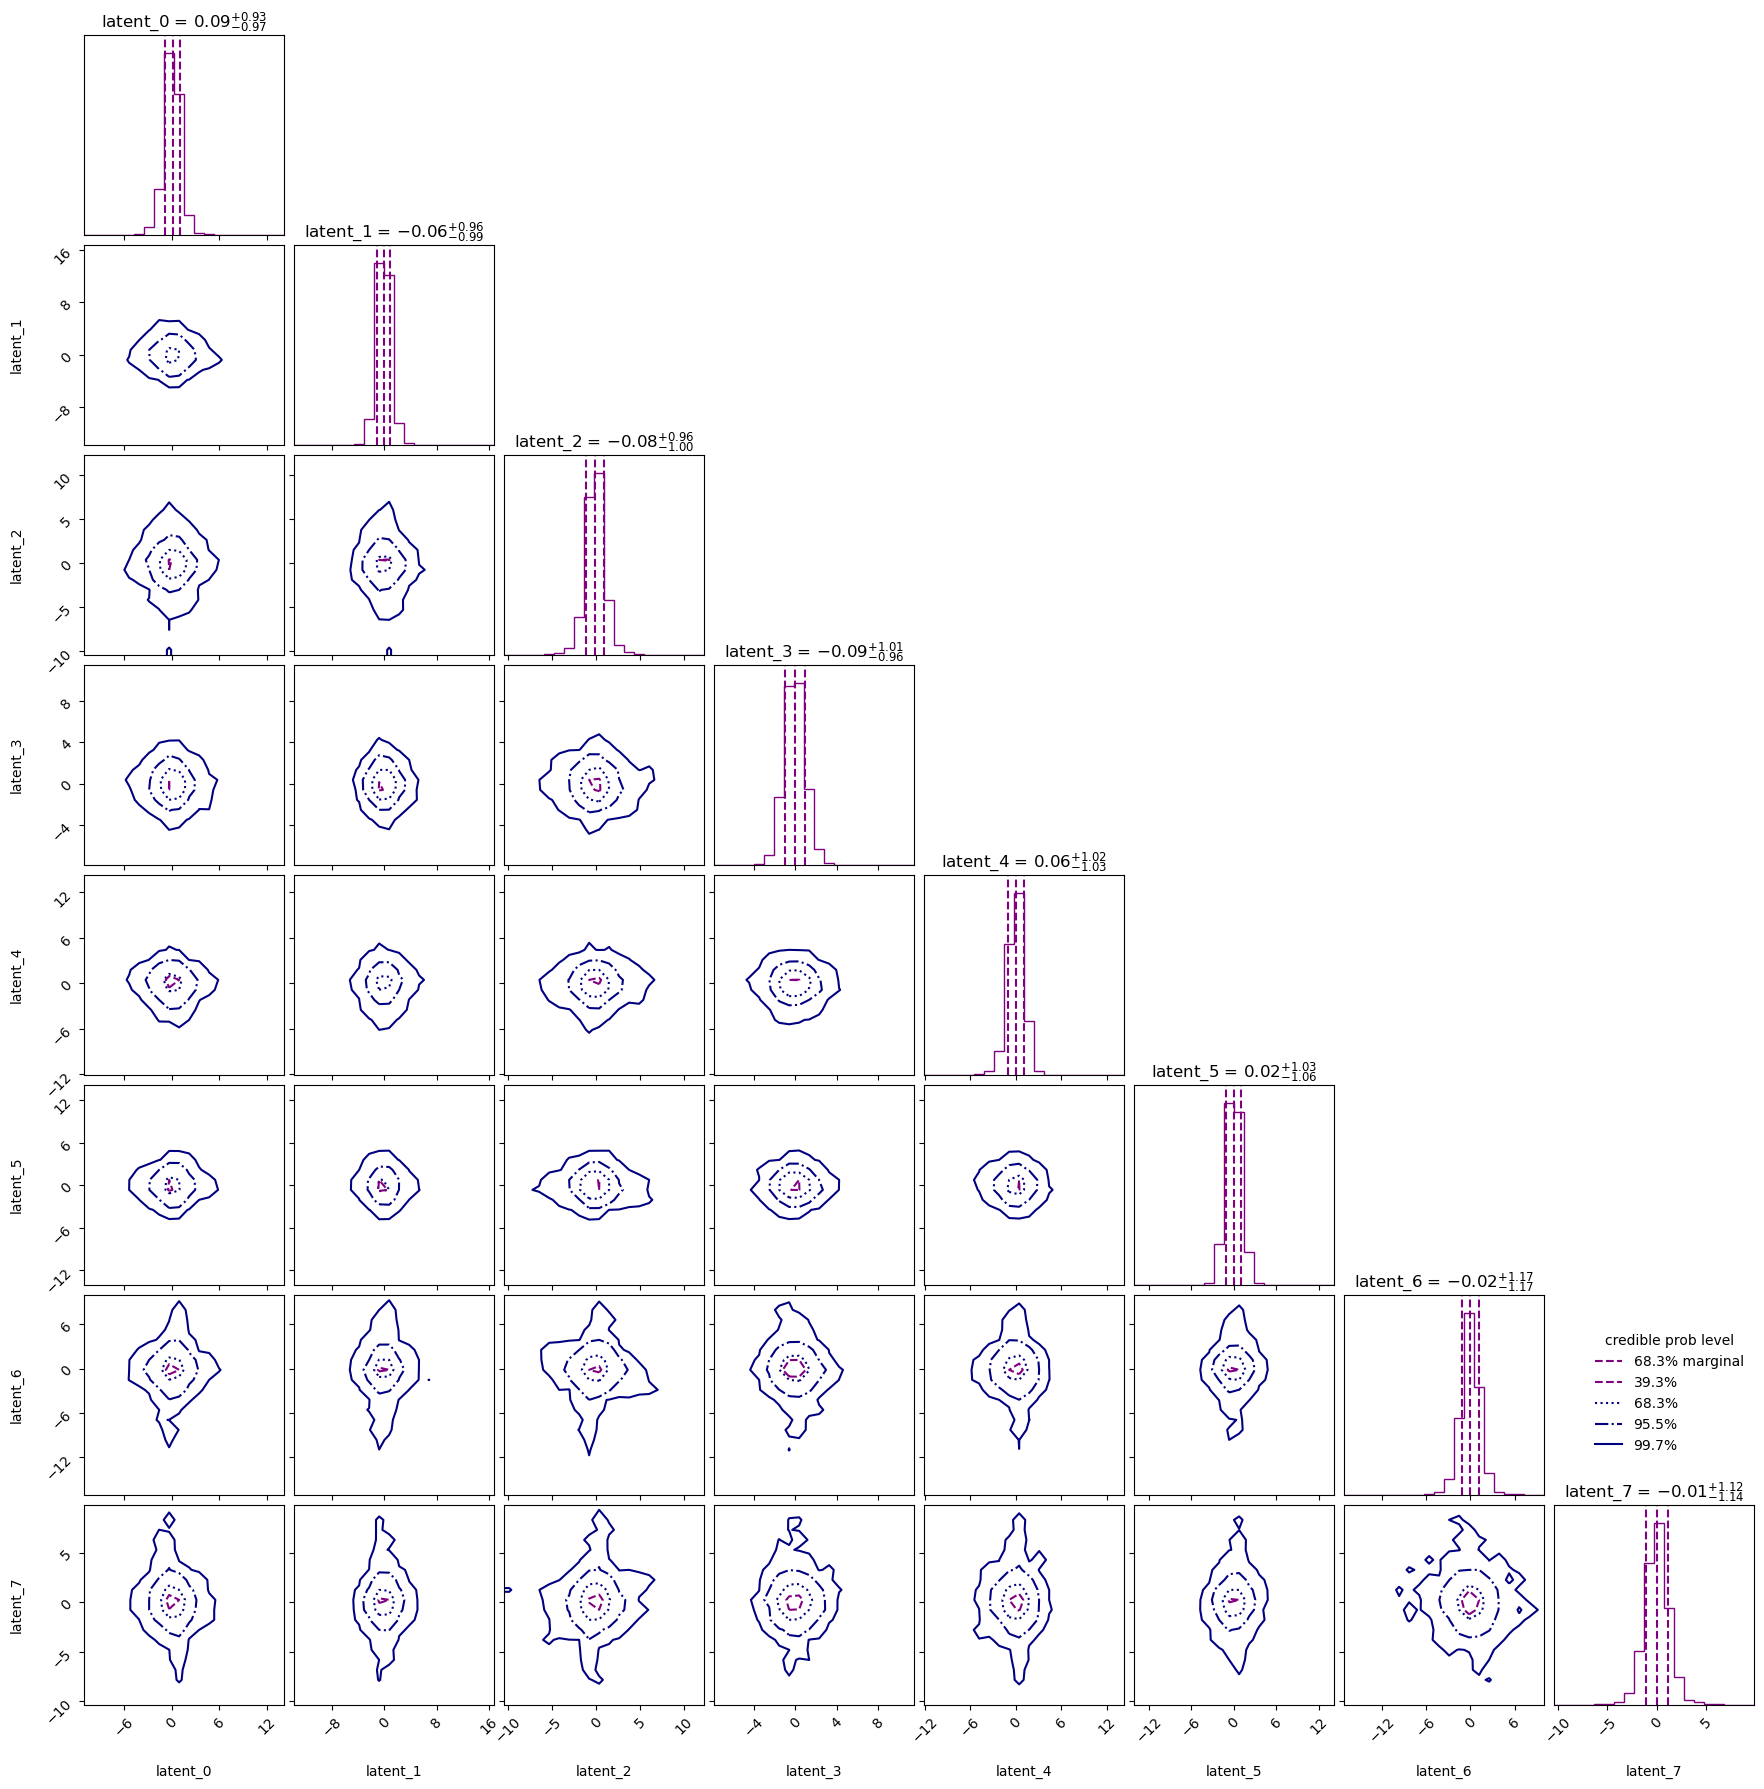

In [363]:
# current_results_neutra.append(result_nn)
cornerplot(current_results_neutra[-1])
plt.show()

In [367]:
with open('ns_neutra_runtimes_2.pickle', 'wb') as f:
    pickle.dump(current_results_neutra, f)

In [368]:
dict_for_plot_nn = {}
for i, n in enumerate(ns_names):
    dict_for_plot_nn[n] = jnp.concatenate([x['transformed_samples'][n] for x in current_results_neutra])


with open('ns_neutra_corner_samples_2.pickle', 'wb') as f:
    pickle.dump(dict_for_plot_nn, f)

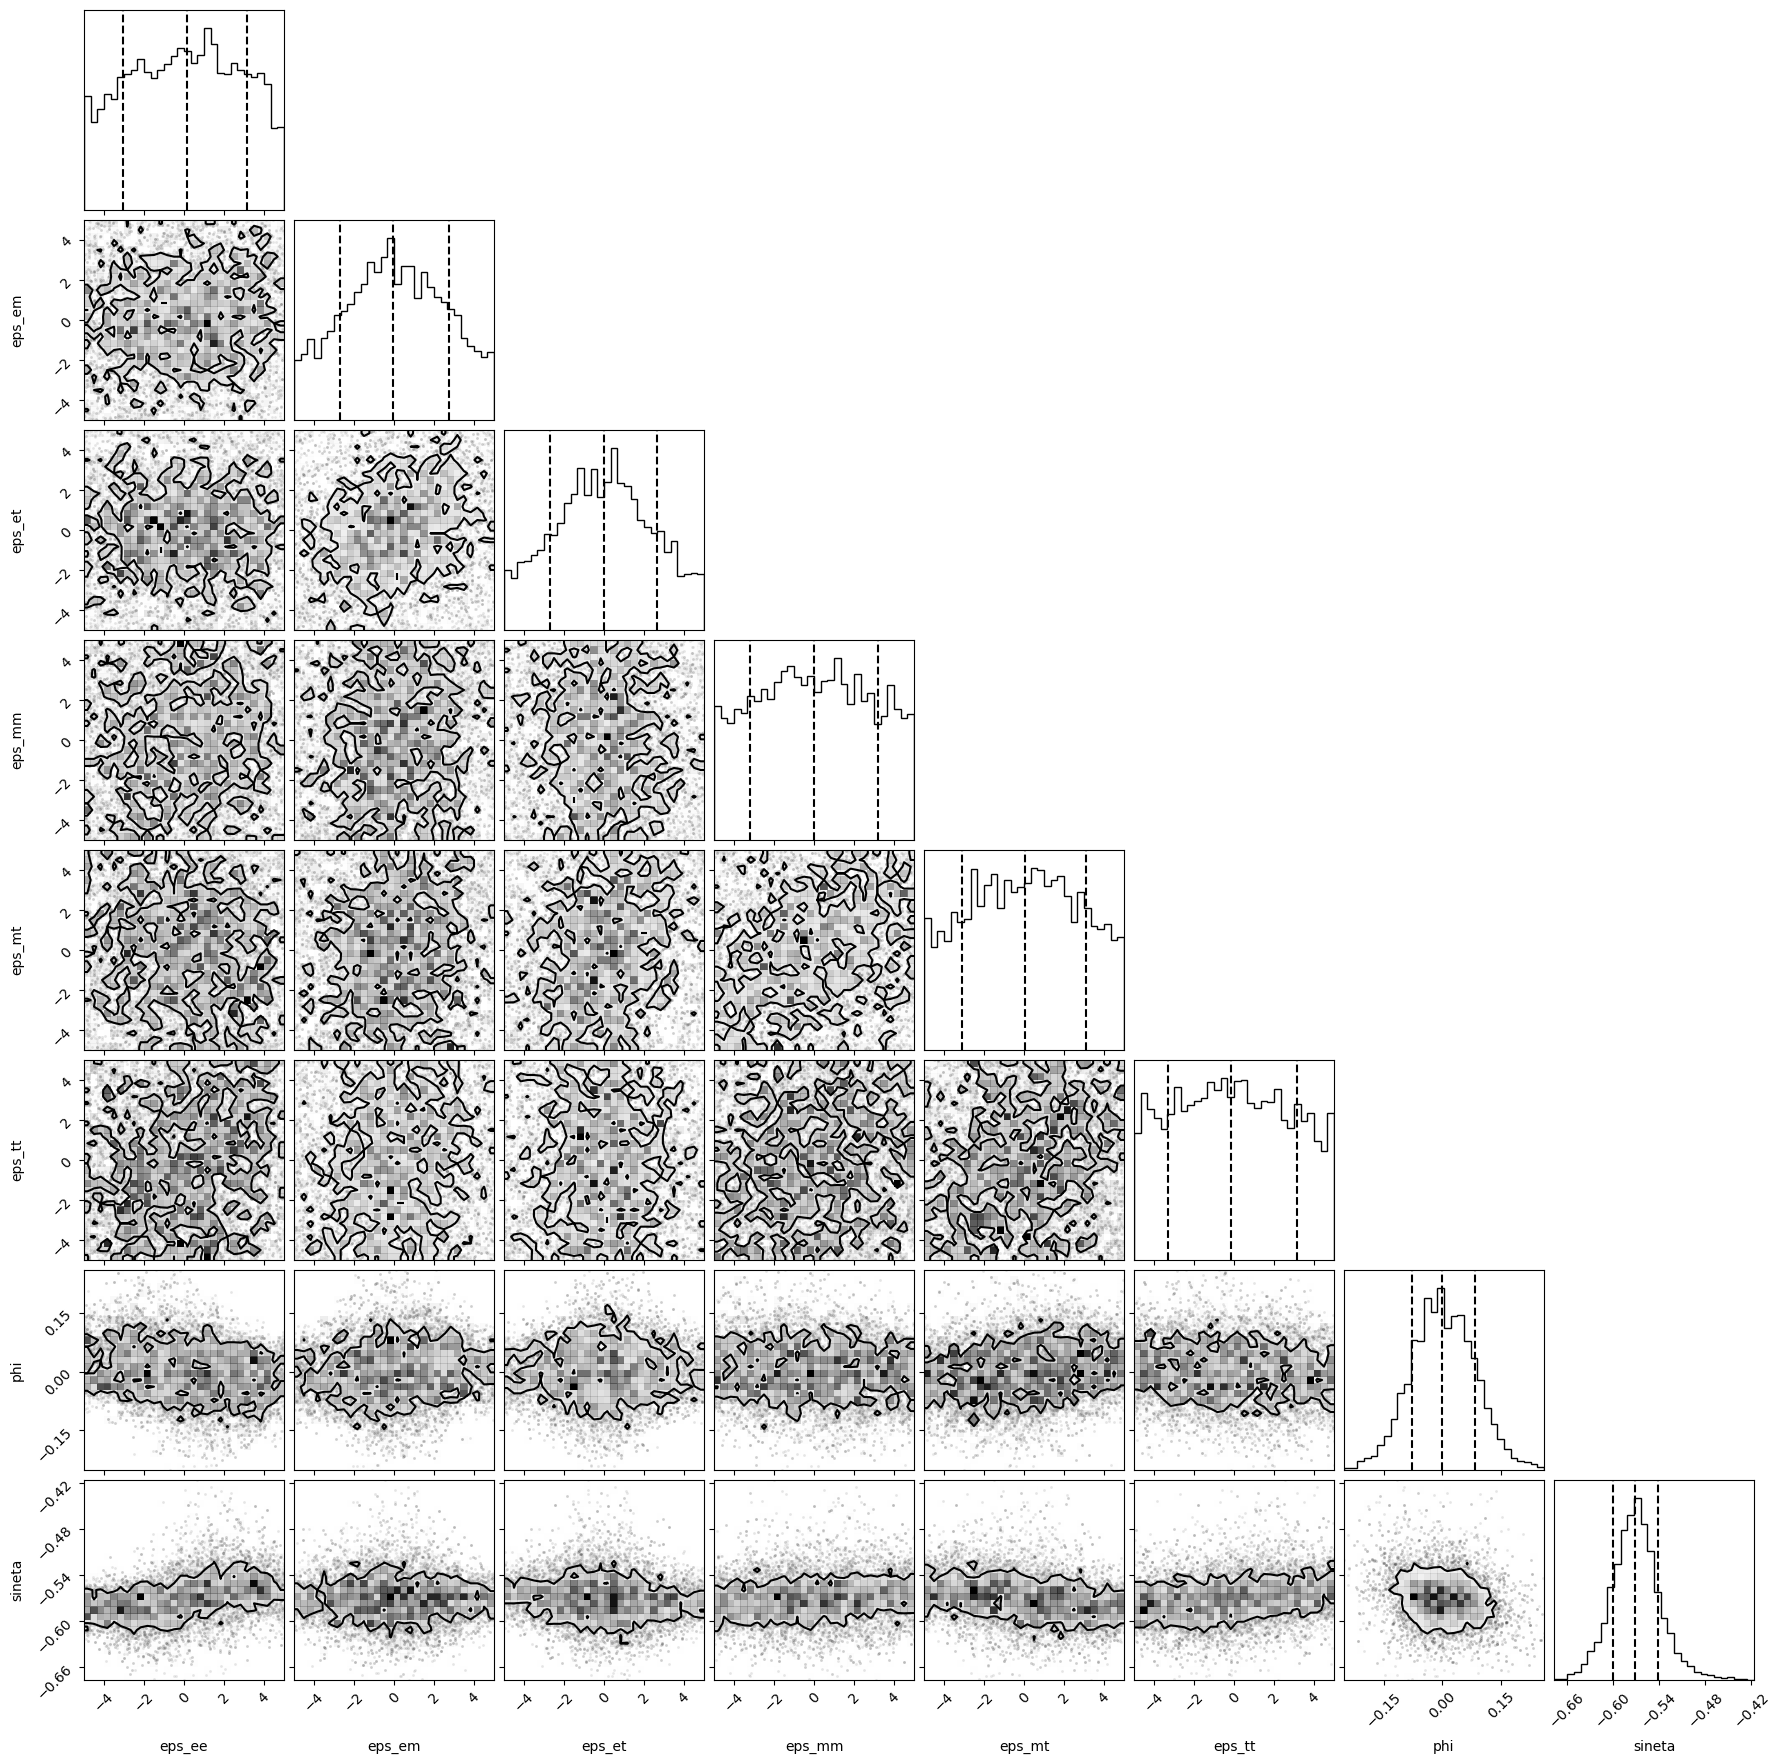

In [369]:
# az_with_nn = az.from_dict(posterior=tree_map(lambda x: x[None], samples_nn_transformed))
fig = corner.corner(samples_nn_transformed, quantiles=[0.16, 0.5, 0.84], bins=30, divergences=True, levels=[0.68])

# Show the plot
fig.show()

In [372]:
def print_params(list_of_things, name):
    ESSes = np.array([x['ess'] for x in list_of_things])
    runtimes = np.array([x['runtime'] for x in list_of_things])
    calls = np.array([x['ncall'] for x in list_of_things])
    print(name + f' ESS per runtime: {np.mean(ESSes/runtimes):0.3e} +/- {np.std(ESSes/runtimes)/np.sqrt(len(list_of_things)):0.3e} \t ESS per call: {np.mean(ESSes/calls):0.3e} +/- {np.std(ESSes/calls)/np.sqrt(len(calls)):0.3e}')

In [373]:
print_params(current_results, 'NS       ')
print_params(current_results_neutra, 'NeuTra NS')

NS        ESS per runtime: 2.823e-01 +/- 9.965e-02 	 ESS per call: 1.712e-03 +/- 6.342e-04
NeuTra NS ESS per runtime: 1.254e+00 +/- 1.602e-01 	 ESS per call: 7.262e-03 +/- 9.257e-04


In [374]:
def print_params_2(list_of_things, name):
    ESSes = np.array([x['ess'] for x in list_of_things])
    runtimes = np.array([x['runtime'] for x in list_of_things])
    calls = np.array([x['ncall'] for x in list_of_things])
    print(name + f' runtime per ESS: {np.mean(runtimes/ESSes):0.3e} +/- {np.std(runtimes/ESSes)/np.sqrt(len(list_of_things)):0.3e} \t calls per ESS: {np.mean(calls/ESSes):0.3e} +/- {np.std(calls/ESSes)/np.sqrt(len(list_of_things)):0.3e}')

In [376]:
print_params_2(current_results, 'NS       ')
print_params_2(current_results_neutra, 'NeuTra NS')

NS        runtime per ESS: 8.511e+00 +/- 3.183e+00 	 calls per ESS: 1.487e+03 +/- 5.524e+02
NeuTra NS runtime per ESS: 8.947e-01 +/- 1.349e-01 	 calls per ESS: 1.547e+02 +/- 2.356e+01


In [385]:
for r in current_results:
    print(r['logz'], r['logzerr'], r['ess'])

-9.711985344064264 0.10612316790032571 4163.677137707396
-9.892172319968463 0.0811383427544596 4111.999615518498
-9.80834562837679 0.1443105965449982 4147.942728076556
-9.9711943133429 0.08763944334365524 4129.594183750422
-9.786850635140993 0.09851201581010663 4127.257244226319
-9.706838196699769 0.07602802157885018 4159.566222804198


In [386]:
for r in current_results_neutra:
    print(r['logz'], r['logzerr'], r['ess'])

-9.78339614492087 0.1384475676915836 4237.336005240337
-9.787517073706637 0.21930027061019114 4198.105753016365
-9.804380574037902 0.1841289880978014 4236.441154753733
-9.612457881894207 0.22809617371883126 4199.009164176951
-9.846600108847598 0.1285728222309563 4278.959523138959
-9.931673956992467 0.14234784127010477 4285.872276298276
